# Fit the complete data (With sWeights and without sWeights)
WITH A LOOP IMPLEMENTED
This file is fitting for different cuts on the BDT variable

- Fit on $m(B^0_s)$ with $m(3\pi)$ around $m(D_s)$ and sWeights
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (gaussian)
    - Background of partially reconstructed decays (gaussian)
    - Combinatorial background (exponential)
- Fit on $m(B^0_s)$ with:
    - Signal $B^0 \to D^{*-} \pi^+ \pi^+ \pi^-$ (sum of two Crystall ball PDF)
    - Background $B^0 \to D^{*-} D_s^+$ from the other fit of the simultaneous fit
    - Background with a misidentified pion: $B^0 \to D^{*-} K^+ \pi^+ \pi^-$ (sum of two crystall ball PDF)
    - Background of partially reconstructed decays $B^0 \to D^{*-} \pi^+ \pi^+ \pi^- h$ (gaussian)
    - Combinatorial background (exponential)
    
    The ratio of yield $\frac{n_{B^0 \to D^{*-} K^+ \pi^+ \pi^-}}{n_{B^0 \to D^{*-} \pi^+ \pi^+ \pi^-}}$is fixed at the value found without any cut on the `BDT` output.

Those two fits are not simultaneous

**Computation of the number of events below the peak.**

We define $\sigma_L$ and $\sigma_R$, the standard deviation of the Crystall ball signal PDFs obtained with the full `common` with only the $143\ MeV < \Delta M < 148\ MeV$ cut.
`frac`, noted $f$, is such that the total signal shape is $f_S = f_r\times p_L +(1-f) p_R$, where $p_L$ ($p_R$) is the left (right) Crystal ball PDF, with standard deviation $\sigma_L$ ($\sigma_R$).
The common mean of the two Crystal Ball PDF is denoted $\mu$

Then, we define the geometrical average $\sigma=\sqrt{(f\sigma_L)^2+((1-f)\sigma_R)^2}$ and the usual average $\sigma_2 = f\times \sigma_L + (1-f) \sigma_R$

The number of combinatorial background under the signal peak, for a given `cut_BDT` is noted `n_B` and computed by:
$$ n_B=\int_{\mu-3\sigma}^{{\mu+3\sigma}}{dx f_e(x, \lambda_{BDT})} \times n_{B,c} $$
Where $n_{B,c}$ is the number of background events between `low` and `high` where the fit is applied. $f_e$ is the exponential combinatorial background PDF.
We also compute this quantity for $\sigma_2$, denoted  $n_{B2}$ or `n_B2`.

Those two quantities and their errors are computed and saved together with the fitted parameters.

Finally, after comparison, I'll chose $\sigma_2$ for the optimisation.

In [10]:
name_BDT = "common_adaboost_without_P_cutDeltaM_highB0M"

## Import

In [1]:
import zfit
import json
import numpy as np
import timeit

from math import sqrt

from bd2dst3pi.locations import loc
from bd2dst3pi.definitions import years, magnets

import sys
sys.path.append(loc.SCRIPTS)

import sys
sys.path.append(loc.SCRIPTS)
from load_save_data import load_data, retrieve_pickle
import plot.histogram as h
from plot.fit import plot_hist_fit_particle
from fit import launch_fit, define_zparams, save_params, format_previous_params, sum_crystalball

Welcome to JupyROOT 6.22/02


## Load

In [2]:
# Mean of the distribution of the partially reconstructed data
with open(f'{loc.JSON}/data_strip_p/all_data_strip_params.json', 'r') as f:
    mu2_p = json.load(f)['mu2']

In [3]:
df_common = load_data(years, magnets, type_data='common', vars=['B0_M', 'BDT'],
                            cut_DeltaM=True, name_BDT="common_adaboost_without_P_cutDeltaM_highB0M")

/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/common_adaboost_without_P_cutDeltaM_highB0M.root


In [4]:
name_data = 'common_bkg_high_B0M'
name_data_B0Ds = 'Ds_recomp_weighted_bkg_high_B0M'
name_data_B0Ds_all = 'all_common_cutDeltaM_Ds23pi_V8'

Loading of $\sigma_R$, $\sigma_L$, `frac` and $\mu$ of the signal shape, of the `common` data.
Those values will be used to integrate the combinatorial PDF in order to get the number of background under the signal peak.

In [5]:
name_full_common = "all_common_cutDeltaM_V8_fixedTails_MC_cor"
with open(f'{loc.JSON}/{name_full_common}_params.json', 'r') as f:
    common_params = json.load(f)


sigmaR = common_params['sigmaR']
sigmaL = common_params['sigmaL']
frac = common_params['frac']
sigm = sqrt((frac*sigmaL)**2 + ((1 - frac)*sigmaR)**2)
sigm2 = frac*sigmaL + (1 - frac)*sigmaR
mea = common_params['mu']
r_bkgK = common_params['r_bkgK']
print('sigm', sigm)
print('sigm2', sigm2)
print('r_bkgK', r_bkgK)

sigm 14.52387729528854
sigm2 18.9695212083598
r_bkgK 0.04390078071823274


## BDT cuts

Reference fit whose results are taken as the starting values of the new fit. It is specified by cut_BDT_ref, the cut on the BDT output. If None, the reference fit is the one performed without any cut on the BDT output.

In [16]:
# l_BDT = []
# l_BDT_ref = []
# # #starting_value = -0.45
# starting_value = -0.45
# end_value      =  0.175
# step           = 0.025


# value = starting_value
# while value <= end_value:
#     if value==0:
#         value = 0
#     l_BDT.append(value)

#     if value <= -0.25:
#         l_BDT_ref.append(None)
#     else:
#         BDT_ref = np.round(l_BDT[-1]-0.025,4)
#         if BDT_ref==0:
#             BDT_ref=0
#         l_BDT_ref.append(BDT_ref)
    
#     value = np.round(value + step, 3)
l_BDT = [0.05]
l_BDT_ref = [0.1]

## Range of the variables

### Weighted `B0_M` with `|tau_M-1969|<50`

In [17]:
low_B0Ds = 5150.
high_B0Ds = 5360.

### full `B0_M`

In [18]:
low = 5150.
high = 5550.

## LOOP

================================ cut_BDT = 0.05 ================================
cut_BDT_ref = 0.1
/afs/cern.ch/user/c/correian/bd2dst3pi/output/root/common/Ds23pi_bkg_high_B0M_BDT0.05.root
/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/B0_M_common_bkg_high_B0M_BDT0.05.pdf
------------------------------------------------------------------
| FCN = -1.846e+05              |     Ncalls=325 (325 total)     |
| EDM = 0.000673 (Goal: 0.001)  |            up = 0.5            |
------------------------------------------------------------------
|  Valid Min.   | Valid Param.  | Above EDM | Reached call limit |
------------------------------------------------------------------
|     True      |     True      |   False   |       False        |
------------------------------------------------------------------
| Hesse failed  |   Has cov.    | Accurate  | Pos. def. | Forced |
------------------------------------------------------------------
|     False     |     True      |   True    |   Tru

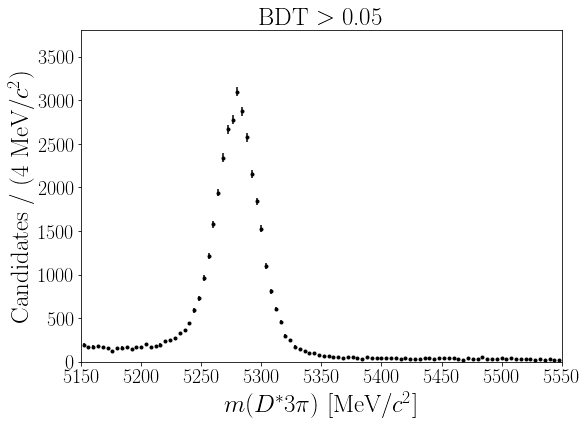

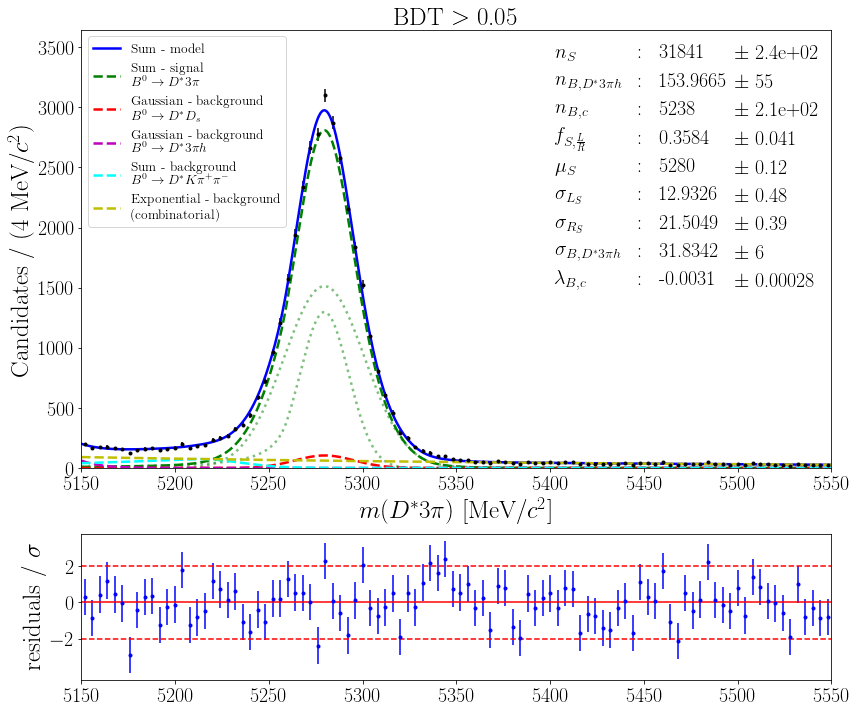

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_bkg_high_B0M/B0_M_common_bkg_high_B0M_detail_fit_BDT0.05.pdf


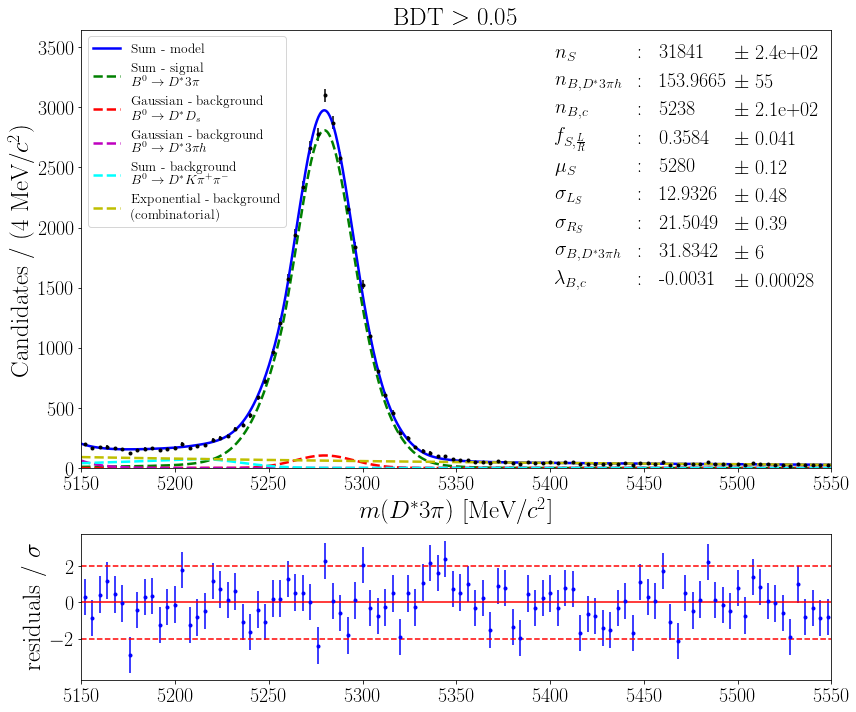

/afs/cern.ch/user/c/correian/bd2dst3pi/output/plots/common_bkg_high_B0M/B0_M_common_bkg_high_B0M_fit_BDT0.05.pdf
1335.168622564322 1747.4857991927909
parameters saved in /afs/cern.ch/user/c/correian/bd2dst3pi/output/json/common_bkg_high_B0M_BDT0.05_params.json


In [19]:
for cut_BDT, cut_BDT_ref in zip(l_BDT, l_BDT_ref):
    
    print(f"================================ cut_BDT = {cut_BDT} ================================")
    print(f"cut_BDT_ref = {cut_BDT_ref}")
    
    ### BDT CUT ========================================================
    k = str(cut_BDT)
    df = df_common.query(f"BDT > {cut_BDT}")
    df_Ds = load_data(years, magnets, type_data='common', vars=['B0_M', 'BDT', 'sWeight'],
                            cut_DeltaM=True, cut_tau_Ds=True, cut_BDT=cut_BDT, name_BDT=name_BDT)
    
    ### cut_BDT_ref ====================================================
    if cut_BDT_ref is None:
        with open(f'{loc.JSON}/{name_full_common}_params.json', 'r') as f:
            params_r = json.load(f)
#         with open(f'{loc.JSON}/all_common_cutDeltaM_Ds_weighted_V8_params.json', 'r') as f:
#             B0Ds_params_r = json.load(f)    
    else:
        with open(f'{loc.JSON}/{name_data}_BDT{cut_BDT_ref}_params.json', 'r') as f:
            params_recup = json.load(f)
        params_r = format_previous_params(params_recup)

#         with open(f'{loc.JSON}/{name_data_B0Ds}_BDT{cut_BDT_ref}_params.json', 'r') as f:
#             B0Ds_params_recup = json.load(f)

#         B0Ds_params_r = format_previous_params(B0Ds_params_recup)
    
    
#     ### FIT ON WEIGHTED B0_M WITH  |tau_M-1969|<50 ====================
#     ## Distribution ..........................
#     h.plot_hist_particle({name_data_B0Ds:df_Ds},'B0_M',
#               low = low_B0Ds, high = high_B0Ds, cut_BDT = k,
#               n_bins = 100, mode_hist = False, colors='black', weights=df_Ds['sWeight'])
    
#     ## Starting point of the fit .............
#     n_events_B0Ds = len(df_Ds.query(f'B0_M > {low_B0Ds} and B0_M < {high_B0Ds}'))

#     if cut_BDT >= 0.2:
#         initial_values_B0Ds = {
#             # Signal
#             'mu_B0Ds'       :{ 'value': B0Ds_params_r['mu_B0Ds']      , 'low': 5279.-4.       , 'high': 5279.+4.             , 'floating': True},
#             'sigma_B0Ds'    :{ 'value': B0Ds_params_r['sigma_B0Ds']   , 'low': 15.-2.        , 'high': 15.+2.                , 'floating': True},
#             'n_sig_B0Ds'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
#             # Combinatorial background
#             'lambda_B0Ds'   :{ 'value': -0.001                        , 'low': -0.15          , 'high': -0.000000001         , 'floating': False},
#             'n_bkg_B0Ds'    :{ 'value': 0                             , 'low': 0              , 'high': n_events_B0Ds        , 'floating': False},
#             # Partially reconstructed particles
#             'mu2_B0Ds'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
#             'sigma2_B0Ds'   :{ 'value': B0Ds_params_r['sigma2_B0Ds']  , 'low': 30.            , 'high': 80.                  , 'floating': True},
#             'n_bkg2_B0Ds'   :{ 'value': n_bkg2_k                      , 'low': 0.              , 'high': n_events_B0Ds        , 'floating': True},
#         }
    
#     else:   
#         n_sig_k = B0Ds_params_r['n_sig_B0Ds']
#         n_bkg_k = B0Ds_params_r['n_bkg_B0Ds']
#         n_bkg2_k = B0Ds_params_r['n_bkg2_B0Ds']

#         initial_values_B0Ds = {
#             # Signal
#             'mu_B0Ds'       :{ 'value': B0Ds_params_r['mu_B0Ds']      , 'low': 5279.-4.       , 'high': 5279.+4.             , 'floating': True},
#             'sigma_B0Ds'    :{ 'value': B0Ds_params_r['sigma_B0Ds']   , 'low': 15.-5.        , 'high': 15.+5.                , 'floating': True},
#             'n_sig_B0Ds'    :{ 'value': n_sig_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
#             # Combinatorial background
#             'lambda_B0Ds'   :{ 'value': B0Ds_params_r['lambda_B0Ds']  , 'low': -0.1           , 'high': -0.0000001           , 'floating': True},
#             'n_bkg_B0Ds'    :{ 'value': n_bkg_k                       , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
#             # Partially reconstructed particles
#             'mu2_B0Ds'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
#             'sigma2_B0Ds'   :{ 'value': B0Ds_params_r['sigma2_B0Ds']  , 'low': 50.            , 'high': 90.                  , 'floating': True},
#             'n_bkg2_B0Ds'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0Ds        , 'floating': True},
#         }
    
#     ## Observable and variables ...................
    
#     obs_B0Ds = zfit.Space("x", limits=(low_B0Ds, high_B0Ds))

#     zparams_B0Ds = define_zparams(initial_values_B0Ds, cut_BDT=cut_BDT)
    
#     ## Name of the params .........................
#     name_params_B0Ds = {
#         # Signal
#         f'mu_B0Ds|BDT{cut_BDT}'      : '$\mu_S$',
#         f'sigma_B0Ds|BDT{cut_BDT}'   : '$\\sigma_S$',
#         f'n_sig_B0Ds|BDT{cut_BDT}'   : '$n_S$',
#         # Combinatorial background
#         f'n_bkg_B0Ds|BDT{cut_BDT}'   : '$n_{B,c}$',
#         f'lambda_B0Ds|BDT{cut_BDT}'  : '$\\lambda_{B,c}$',
#         # Partially reconstructed background
#         f'mu2_B0Ds|BDT{cut_BDT}'     : '$\\mu_{B, D^*3 D_s h}$',
#         f'sigma2_B0Ds|BDT{cut_BDT}'  : '$\\sigma_{B, D^* D_s h}$',
#         f'n_bkg2_B0Ds|BDT{cut_BDT}'  : '$n_{B, D^* D_s h}$',
#     }
    
#     ## PDFs .....................................
#     gaussianS_B0Ds = zfit.pdf.Gauss(zparams_B0Ds[f'mu_B0Ds'],zparams_B0Ds['sigma_B0Ds'],obs=obs_B0Ds)
#     exponential_B0Ds = zfit.pdf.Exponential(zparams_B0Ds['lambda_B0Ds'], obs=obs_B0Ds)
#     gaussian_B0Ds = zfit.pdf.Gauss(zparams_B0Ds['mu2_B0Ds'],zparams_B0Ds['sigma2_B0Ds'],obs=obs_B0Ds)

#     gaussianS_B0Ds_ext = gaussianS_B0Ds.create_extended(zparams_B0Ds['n_sig_B0Ds'])
#     exponential_B0Ds_ext = exponential_B0Ds.create_extended(zparams_B0Ds['n_bkg_B0Ds'])
#     gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams_B0Ds['n_bkg2_B0Ds'])

#     model_B0Ds = zfit.pdf.SumPDF([gaussianS_B0Ds_ext, exponential_B0Ds_ext, gaussian_B0Ds_ext])
#     data_B0Ds = zfit.Data.from_pandas(df_Ds['B0_M'], obs=obs_B0Ds, weights=df_Ds['sWeight']) 
    
#     ## Do the fit ...............................
#     start = timeit.default_timer()
#     result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)
#     result_B0Ds, params_B0Ds = launch_fit( model_B0Ds, data_B0Ds, extended=True)
#     stop = timeit.default_timer()
#     print('Time to do the fit: ', stop - start)     
    
#     ## Plot and save the fit ....................
#     name_data_B0Ds_plot = name_data_B0Ds
#     plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
#                            name_models = ["", '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
#                                           '\n (combinatorial)'], cut_BDT=k,
#                            obs=obs_B0Ds, n_bins = 100,mode_hist = False,
#                            name_data = name_data_B0Ds, name_folder=name_data,
#                            colors=['b','r','magenta','y'], weights=df_Ds['sWeight'],
#                            params=params_B0Ds,name_params=name_params_B0Ds,
#                            colWidths=[0.05,0.01,0.05,0.04],
#                            fontsize_res = 18.,
#                            fontsize_leg=15)

#     n_bins=50
#     name_data_B0Ds_plot = name_data_B0Ds+str(n_bins)

#     plot_hist_fit_particle(df_Ds,'B0_M', models = [model_B0Ds, gaussianS_B0Ds_ext, gaussian_B0Ds_ext, exponential_B0Ds_ext],
#                            name_models = ["", '\n $B^0\\to D^*D_s$','\n $B^0\\to D^*D_s h$',
#                                           '\n (combinatorial)'], cut_BDT=k,
#                            obs=obs_B0Ds, n_bins = n_bins,mode_hist = False,
#                            name_data = name_data_B0Ds, name_folder=name_data,
#                            colors=['b','r','magenta','y'], weights=df_Ds['sWeight'],
#                            params=params_B0Ds,name_params=name_params_B0Ds,
#                            colWidths=[0.05,0.01,0.05,0.04],
#                            fontsize_res = 18.,
#                            fontsize_leg=15)
#     save_params(params_B0Ds, name_data_B0Ds+f'_BDT{cut_BDT}', True)
    
    
    ### FIT ON B0_M ============================================================
    ## Distribution ............................
    h.plot_hist_particle({name_data:df},'B0_M',
              low = low, high = high, cut_BDT=cut_BDT,
              n_bins = 100, mode_hist = False, colors='black')
    
    

    ## Load data ...............................
    #  Result of the fit on the MC D0S->D*pipipi data with one of the pi misidentified as a kaon
    with open(f'{loc.JSON}/data_KPiPi_2_params.json', 'r') as f:
        data_KPiPi_params = json.load(f)

    for var in 'muL', 'muR', 'sigmaL', 'sigmaR': # conversion GeV -> MeV
        data_KPiPi_params[var] = data_KPiPi_params[var]*1000
        data_KPiPi_params[f"{var}_err"] = data_KPiPi_params[f"{var}_err"]*1000    

    # Result of the previous fit on the B0_M sWeighted distribution with cut on tau_M around m(Ds)
    with open(f'{loc.JSON}/{name_data_B0Ds}_BDT{cut_BDT}_params.json', 'r') as f:
        data_B0Ds_params = json.load(f)

    # Result of the fit on the MC signal data
    with open(f'{loc.JSON}/MC_cor_params.json', 'r') as f:
        MC_param_results = json.load(f)
    
    ## Starting point of the fit ...............
#     with open(f'{loc.JSON}/{name_full_common}_params.json', 'r') as f:
#             full_params = json.load(f)
            
    n_events_B0_M = len(df.query(f'B0_M > {low} and B0_M < {high}'))

    n_sig_k = params_r['n_sig']
    n_bkg_k = params_r['n_bkg']
    n_bkg2_k = params_r['n_bkg2']
    
    if cut_BDT >= 0.2:
        with open(f'{loc.JSON}/{name_data}_BDT0.15_params.json', 'r') as f:
            sigma2 = json.load(f)['sigma2|BDT0.15']

        initial_values = {
            # Signal        
            'mu'       :{ 'value': params_r['mu']                , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
            'sigmaL'   :{ 'value': params_r['sigmaL']            , 'low': 17.-15.        , 'high': 17.+15.              , 'floating': True},
            'sigmaR'   :{ 'value': params_r['sigmaR']            , 'low': 17.-15.        , 'high': 17+15.               , 'floating': True},
            'alphaL'   :{ 'value': MC_param_results['alphaL_MC']    , 'low': 0.1            , 'high': 10.                  , 'floating': False},
            'alphaR'   :{ 'value': -MC_param_results['alphaR_MC']     , 'low': -10.            , 'high': -0.1                , 'floating': False},
            'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
            'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
            'frac'     :{ 'value': params_r['frac']              , 'low': 0.1              , 'high': 1.                 , 'floating': True},
            'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
            # Combinatorial background        
            'lambda'   :{ 'value': params_r['lambda']            , 'low': -0.01          , 'high': -0.00001             , 'floating': True},
            'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
            # Partially reconstructed particles        
            'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
            'sigma2'   :{ 'value': sigma2                        , 'low': 10.            , 'high': 5150.-mu2_p          , 'floating': False},
            'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
            # Background decay D*Kpipi    
        #     'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
            'r_bkgK'   :{ 'value': r_bkgK                        , 'low': 0.0001          , 'high': 0.5                   , 'floating': False},
        }
    else:

        initial_values = {
            # Signal        
            'mu'       :{ 'value': params_r['mu']                , 'low': 5279.-5.       , 'high': 5279.+5.             , 'floating': True},
            'sigmaL'   :{ 'value': params_r['sigmaL']            , 'low': 17.-15.        , 'high': 17.+15.              , 'floating': True},
            'sigmaR'   :{ 'value': params_r['sigmaR']            , 'low': 17.-15.        , 'high': 17+15.               , 'floating': True},
            'alphaL'   :{ 'value': MC_param_results['alphaL_MC'] , 'low': 0.1            , 'high': 10.                  , 'floating': False},
            'alphaR'   :{ 'value': -MC_param_results['alphaR_MC'], 'low': -10.            , 'high': -0.1                , 'floating': False},
            'nL'       :{ 'value': MC_param_results['nL_MC']     , 'low': 0.1            , 'high': 200.                 , 'floating': False},
            'nR'       :{ 'value': MC_param_results['nR_MC']     , 'low': 1.             , 'high': 200.                 , 'floating': False},
            'frac'     :{ 'value': params_r['frac']              , 'low': 0.1              , 'high': 1.                 , 'floating': True},
            'n_sig'    :{ 'value': n_sig_k                       , 'low': n_sig_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
            # Combinatorial background        
            'lambda'   :{ 'value': params_r['lambda']            , 'low': -0.01          , 'high': -0.00001             , 'floating': True},
            'n_bkg'    :{ 'value': n_bkg_k                       , 'low': n_bkg_k*0.5    , 'high': n_events_B0_M        , 'floating': True},
            # Partially reconstructed particles        
            'mu2'      :{ 'value': mu2_p                         , 'low': 4800.          , 'high': 5150.                , 'floating': False},
            'sigma2'   :{ 'value': params_r['sigma2']            , 'low': 10.            , 'high': 5150.-mu2_p          , 'floating': True},
            'n_bkg2'   :{ 'value': n_bkg2_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
            # Background decay D*Kpipi    
        #     'n_bkgK'   :{ 'value': n_bkgK_k                      , 'low': 0              , 'high': n_events_B0_M        , 'floating': True},
            'r_bkgK'   :{ 'value': r_bkgK                        , 'low': 0.0001          , 'high': 0.5                   , 'floating': False},
        }
    
    for var in 'muL', 'muR', 'sigmaL', 'sigmaR', 'nL', 'nR', 'alphaL', 'alphaR', 'nL', 'nR', 'fraction':
        initial_values[f'{var}_K'] = {'value': data_KPiPi_params[var], 'low': None, 'high': None, 'floating': False}

    for var in 'mu', 'sigma', 'n_sig' :
        initial_values[f'{var}_Ds'] = {'value': data_B0Ds_params[f'{var}_B0Ds|BDT{cut_BDT}'], 'low': None, 'high': None, 'floating': False}

    ## Observable and variables .................
    obs = zfit.Space("x", limits=(low, high))

    zparams = define_zparams(initial_values, cut_BDT=cut_BDT)


    mult = lambda r, n: r*n
    zparams["n_bkgK"] = zfit.ComposedParameter(f"n_bkgK|BDT{cut_BDT}", mult, params=[zparams['r_bkgK'],zparams['n_sig']])    

    ## Name of the params .......................
    name_params = {
        # Signal
        f'mu|BDT{cut_BDT}'      : '$\mu_S$',
        f'sigmaL|BDT{cut_BDT}'  : '$\\sigma_{L_S}$',
        f'sigmaR|BDT{cut_BDT}'  : '$\\sigma_{R_S}$',    
        f'alphaL|BDT{cut_BDT}'  : '$\\alpha_{L_S}$',
        f'alphaR|BDT{cut_BDT}'  : '$\\alpha_{R_S}$',
        f'nL|BDT{cut_BDT}'      : '$n_L_S$',
        f'nR|BDT{cut_BDT}'      : '$n_R_S$',
        f'frac|BDT{cut_BDT}'    : '$f_{S, \\frac{L}{R}}$',
        f'n_sig|BDT{cut_BDT}'   : '$n_S$',
        # Combinatorial background
        f'n_bkg|BDT{cut_BDT}'   : '$n_{B,c}$',
        f'lambda|BDT{cut_BDT}'  : '$\\lambda_{B,c}$',
        # Partially reconstructed brackground
        f'mu2|BDT{cut_BDT}'     : '$\\mu_{B,D^*3\pi h}$',
        f'sigma2|BDT{cut_BDT}'  : '$\\sigma_{B,D^*3\pi h}$',
        f'n_bkg2|BDT{cut_BDT}'  : '$n_{B,D^*3\pi h}$',
        # Background decay D*Kpipi    
        f'n_bkgK|BDT{cut_BDT}'  : '$n_{B,D^*K\pi\pi}$',
        f'r_bkgK|BDT{cut_BDT}'  : '$\\frac{n_{B,D^*K\pi\pi}}{n_S}$',
    }
    
    ## PDFs .....................................
    model_S, crystalBallL_S, crystalBallR_S = sum_crystalball(zparams['mu'], zparams['mu'],
                                                              zparams['sigmaL'], zparams['sigmaR'],
                                                              zparams['frac'], obs,                                                          
                                                              zparams['alphaL'], zparams['alphaR'], 
                                                              zparams['nL'], zparams['nR']
                                                             )


    gaussian_B0Ds = zfit.pdf.Gauss(zparams['mu_Ds'],zparams['sigma_Ds'],obs=obs)

    model_K, crystalBallL_K, crystalBallR_K = sum_crystalball(zparams['muL_K'], zparams['muR_K'], 
                                                              zparams['sigmaL_K'], zparams['sigmaR_K'],
                                                              zparams['fraction_K'], obs,
                                                              zparams['alphaL_K'], zparams['alphaR_K'], 
                                                              zparams['nL_K'], zparams['nR_K'])

    exponential = zfit.pdf.Exponential(zparams['lambda'], obs=obs)
    gaussian = zfit.pdf.Gauss(zparams['mu2'],zparams['sigma2'],obs=obs)


    model_S_ext = model_S.create_extended(zparams['n_sig'])
    exp_ext = exponential.create_extended(zparams['n_bkg'])
    gaussian_ext = gaussian.create_extended(zparams['n_bkg2'])
    gaussian_B0Ds_ext = gaussian_B0Ds.create_extended(zparams['n_sig_Ds'])
    model_K_ext = model_K.create_extended(zparams['n_bkgK'])

    model = zfit.pdf.SumPDF([model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext, exp_ext]) # gauss is folded by frac
    data = zfit.Data.from_pandas(df['B0_M'], obs=obs)
    
    ## Do the fit ...............................
    start = timeit.default_timer()
    result, params = launch_fit(model, data, extended=True)
    result, params = launch_fit(model, data, extended=True)
    stop = timeit.default_timer()
    print('Time to do the fit: ', stop - start) 
    
    ## Plot and save the fit ....................
    name_data_plot = name_data + '_detail'
    plot_hist_fit_particle(df,'B0_M', models = [model,[model_S_ext, crystalBallL_S, crystalBallR_S], gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                           name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                          '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                           cut_BDT=cut_BDT,
                           obs=obs, n_bins = 100,mode_hist = False,
                           name_data = name_data_plot, name_folder=name_data,
                           colors=['b','g','r','m','cyan','y'],
                           params=params,name_params=name_params,
                           fontsize_leg=13.5,
                           colWidths=[0.06,0.01,0.05,0.06]
                          )
    name_data_plot = name_data
    plot_hist_fit_particle(df,'B0_M', models = [model,model_S_ext, gaussian_B0Ds_ext, gaussian_ext, model_K_ext,exp_ext],
                           name_models = ["", '\n $B^0\\to D^* 3\pi$','\n $B^0\\to D^*D_s$','\n $B^0\\to D^*3\pi h$',
                                          '\n $B^0\\to D^* K \pi^+\pi^-$','\n (combinatorial)'],
                           cut_BDT=cut_BDT,
                           obs=obs, n_bins = 100,mode_hist = False,
                           name_data = name_data_plot, name_folder=name_data,
                           colors=['b','g','r','m','cyan','y'],
                           params=params,name_params=name_params,
                           fontsize_leg=13.5,
                           colWidths=[0.06,0.01,0.05,0.06])
    
    ## Number of combi background events under the signal peak ...
    integral = float(exp_ext.analytic_integrate([mea-3*sigm, mea+3*sigm]))
    integral2 = float(exp_ext.analytic_integrate([mea-3*sigm2, mea+3*sigm2]))

    n_bkg = float(zparams['n_bkg'].value())
    n_bkg_err = params[zparams['n_bkg']]['minuit_hesse']['error']
    n_B = integral * n_bkg
    n_B_err = integral * n_bkg_err

    n_B2 = integral2 * n_bkg
    n_B2_err = integral2 * n_bkg_err
    print(n_B, n_B2)
    save_params(params,name_data + f"_BDT{cut_BDT}", True, {'n_B':n_B, 'n_B_err':n_B_err, 'n_B2':n_B2, 'n_B2_err':n_B2_err})